In [20]:

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle

In [21]:
def data_collect(Path):
    files=os.listdir(Path)
    random.shuffle(files)
    Train_Lstm=[]
    Label=[]
    Train=[]
    Train
    count=1
    Train_Pdf=[]
    for file in files:
        start=time.time()
        Break=0
        global Train_pdf, Label_Pdf
        Train_lstm=[]
        file_data=os.listdir(Path+file)
        
        ##CNN_PDF
        #CSFV2
        df_csfv2 = pd.read_csv(Path+file+'/'+file_data[0],header=None)
        df_era5 = pd.read_csv(Path+file+'/'+file_data[1],header=None)
        for column in df_csfv2.columns[2:12]:
            if column == df_csfv2.columns[2]:
                Train_pdf=np.array(np.array(df_csfv2[column]).reshape(61,111,1))
            else:
                Train_pdf=np.append(Train_pdf,np.array(df_csfv2[column]).reshape(61,111,1),axis=2)
                
        #ERAF
        for column in df_era5.columns[2:7]:
            Train_pdf=np.append(Train_pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        ##LSTM
        #ERA5
        df_1 = pd.read_csv(Path+file+'/'+file_data[3])
        for column in df_1.columns[1:91]:
            if' NaN' in list(df_1[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_1[column]))
            
        #CSFV2
        df_2 = pd.read_csv(Path+file+'/'+file_data[2])
        for column in df_2.columns[1:181]:
            if' NaN' in list(df_2[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_2[column]))
        if Break==1:
            continue

        ##LABEL_PDF 
        for column in df_era5.columns[7:17]:
            if column == df_era5.columns[7]:
                Label_Pdf=np.array(np.array(df_era5[column]).reshape(61,111,1))
                #print(Label_Pdf)
            else:
                Label_Pdf=np.append(Label_Pdf,np.array(df_era5[column]).reshape(61,111,1),axis=2)

        Train_Pdf.append(Train_pdf)
        Train_Lstm.append(Train_lstm)
        Label.append(Label_Pdf)
        end=time.time()
        Time=(end-start)*(len(files)-count)
        print('%d / %d , Time : %d : %d : %d'%(count,len(files),int(Time/3600),int(Time%3600/60),Time%3600%60),end='\r')
        count=count+1
    Train.append(Train_Pdf)
    Train.append(Train_Lstm)
    Label=np.array(Label)
    return Train,Label

In [23]:
#資料位置
Path='D:/weather/data_180_USA_oneyear/Train/'


#模型儲存位置
Path_model = 'D:/weather/model_usa/LSMT_Restnet_new_data_my_loss_only_LSTM_180days.h5'

#載入資料
Train,Label=data_collect(Path)

In [29]:
model=Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (270, 10)))
model.add(LSTM(units = 32, return_sequences = True))
model.add(Lambda(lambda x: x[-180:, :]))
model.add(Flatten())
model.add(Dense(10000))
model.add(Dense(111*61*10, activation='linear'))
model.add(Reshape((61,111,10)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 270, 128)          71168     
_________________________________________________________________
lstm_5 (LSTM)                (None, 270, 32)           20608     
_________________________________________________________________
lambda_2 (Lambda)            (None, 270, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8640)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10000)             86410000  
_________________________________________________________________
dense_5 (Dense)              (None, 61610)             616161610 
_________________________________________________________________
reshape_2 (Reshape)          (None, 61, 101, 10)      

In [30]:
#資料轉換格式
Train_Pdf=Train[0]
Train_Lstm=Train[1]
Train_Pdf=np.array(Train_Pdf)
Train_Lstm=np.array(Train_Lstm)
print('Train_Lstm:',Train_Lstm.shape)
print('Train_Pdf:',Train_Pdf.shape)
Train_Pdf_List=Train_Pdf.tolist()

In [35]:
#儲存最大、最小、平均值
Max=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Min=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]
Mean=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
count=0
for i in range(len(Train_Pdf_List)):
    for j in range(len(Train_Pdf_List[0])):
        for x in range(len(Train_Pdf_List[0][0])):
            for y in range(len(Train_Pdf_List[0][0][0])):
                if Train_Pdf_List[i][j][x][y]>Max[y]:
                    Max[y]=Train_Pdf_List[i][j][x][y]
                if Train_Pdf_List[i][j][x][y]<Min[y]:
                    Min[y]=Train_Pdf_List[i][j][x][y]
                Mean[y]=Mean[y]+Train_Pdf_List[i][j][x][y] 
            count=count+1


In [36]:
Max=Max[:10]
Min=Min[:10]
Mean=Mean[:10]
for i in range(10):
    Mean[i]=Mean[i]/count

In [ ]:
print('Mean:',Mean)
print('Max:',Max)
print('Min:',Min)

In [40]:
def mcustom_loss(y_true, y_pred):

    trueAvg = (y_true[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    trueStd = (y_true[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    trueMax = (y_true[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    trueMin = (y_true[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    trueSkw = (y_true[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])

    predAvg = (y_pred[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    predStd = (y_pred[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    predMax = (y_pred[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    predMin = (y_pred[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    predSkw = (y_pred[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])
    
    trueAvg_180 = (y_true[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    trueStd_180 = (y_true[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    trueMax_180 = (y_true[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    trueMin_180 = (y_true[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    trueSkw_180 = (y_true[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    predAvg_180 = (y_pred[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    predStd_180 = (y_pred[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    predMax_180 = (y_pred[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    predMin_180 = (y_pred[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    predSkw_180 = (y_pred[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    loss = ((K.square(predMin - trueMin) + K.square(predMax - trueMax) + K.square(predSkw - trueSkw) +
            K.square(predAvg - trueAvg) + K.square(predStd - trueStd))+
            (K.square(predMin_180 - trueMin_180) + K.square(predMax_180 - trueMax_180) + K.square(predSkw_180 - trueSkw_180) +
            K.square(predAvg_180 - trueAvg_180) + K.square(predStd_180 - trueStd_180)))/10
    loss = K.mean(loss, axis=-1)

    return loss

In [41]:
model_checkpoint_callback=ModelCheckpoint(Path_model, monitor='val_loss', verbose=1, save_best_only=True)
model.compile(optimizer = 'adam', loss = mcustom_loss,run_eagerly=True)

histroy=model.fit(Train_Lstm,Label,
          batch_size=16,
          validation_split=0.2,
          epochs=100,
          callbacks=[model_checkpoint_callback]
         )

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
139/139 [==============================] - ETA: 0s - loss: 0.4721
Epoch 00001: val_loss improved from inf to 0.00829, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_LSTM_180days.h5
139/139 [==============================] - 302s 2s/step - loss: 0.4721 - val_loss: 0.0083
Epoch 2/100
139/139 [==============================] - ETA: 0s - loss: 0.0090
Epoch 00002: val_l

139/139 [==============================] - 284s 2s/step - loss: 0.0044 - val_loss: 0.0038
Epoch 32/100
139/139 [==============================] - ETA: 0s - loss: 0.0045
Epoch 00032: val_loss did not improve from 0.00381
139/139 [==============================] - 236s 2s/step - loss: 0.0045 - val_loss: 0.0043
Epoch 33/100
139/139 [==============================] - ETA: 0s - loss: 0.0040
Epoch 00033: val_loss did not improve from 0.00381
139/139 [==============================] - 234s 2s/step - loss: 0.0040 - val_loss: 0.0051
Epoch 34/100
139/139 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00034: val_loss did not improve from 0.00381
139/139 [==============================] - 236s 2s/step - loss: 0.0042 - val_loss: 0.0042
Epoch 35/100
139/139 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00035: val_loss did not improve from 0.00381
139/139 [==============================] - 234s 2s/step - loss: 0.0048 - val_loss: 0.0078
Epoch 36/100
139/139 [========

Epoch 65/100
139/139 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00065: val_loss improved from 0.00261 to 0.00249, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_LSTM_180days.h5
139/139 [==============================] - 296s 2s/step - loss: 0.0026 - val_loss: 0.0025
Epoch 66/100
139/139 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00066: val_loss did not improve from 0.00249
139/139 [==============================] - 236s 2s/step - loss: 0.0027 - val_loss: 0.0027
Epoch 67/100
139/139 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00067: val_loss improved from 0.00249 to 0.00234, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_LSTM_180days.h5
139/139 [==============================] - 287s 2s/step - loss: 0.0026 - val_loss: 0.0023
Epoch 68/100
139/139 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00068: val_loss did not improve from 0.00234
139/139 [=======================

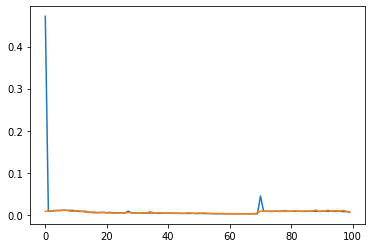

In [42]:
import matplotlib.pyplot as plt
plt.plot(histroy.history['loss']) 
plt.plot(histroy.history['val_loss']) 